# Task on Empathy Emotion and Personality Detection in Interactions: Predicting Perceived Empathy and Emotion in Conversations (CONV)

#### Importing the required libraries

In [1]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, f1_score

import xgboost as xgb
import string

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize NLTK tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package punkt to C:\Users\Its
[nltk_data]     Me\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Its
[nltk_data]     Me\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Its
[nltk_data]     Me\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Loading training data
train_conv = pd.read_csv('C:/Users/Its Me/Desktop/train_conv.tsv', sep='\t')

In [3]:
train_conv.head()

,conversation_id,turn_id,text,EmotionalPolarity,Emotion,Empathy,speaker_number,article_id,speaker_id,essay_id
0,2,0,I feel very sad for the people.,2.0000,3.0000,3.3333,1,35.0,30.0,1.0
1,2,1,It's terrible. Not only the people but the ani...,2.0000,4.0000,3.3333,2,35.0,17.0,501.0
2,2,10,I felt really sorry for the sister that now ha...,2.0000,3.6667,2.6667,1,35.0,30.0,1.0
3,2,11,"Yeah, it's going to be tough but i am sure she...",0.6667,3.0000,2.0000,2,35.0,17.0,501.0
4,2,12,"Yeah, we never know what we can do unless we a...",0.3333,2.3333,1.3333,1,35.0,30.0,1.0


In [4]:
# To display (rows, columns)
print("Training Data Shape:", train_conv.shape)

Training Data Shape: (8776, 10)


In [5]:
#To display basic info
train_conv.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8776 entries, 0 to 8775
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   conversation_id    8776 non-null   int64  
 1   turn_id            8776 non-null   int64  
 2   text               8776 non-null   object 
 3   EmotionalPolarity  8776 non-null   float64
 4   Emotion            8776 non-null   float64
 5   Empathy            8776 non-null   float64
 6   speaker_number     8776 non-null   int64  
 7   article_id         8776 non-null   float64
 8   speaker_id         8776 non-null   float64
 9   essay_id           8776 non-null   float64
dtypes: float64(6), int64(3), object(1)
memory usage: 685.8+ KB


In [6]:
# Datatypes for each column
train_conv.dtypes


conversation_id        int64
turn_id                int64
text                  object
EmotionalPolarity    float64
Emotion              float64
Empathy              float64
speaker_number         int64
article_id           float64
speaker_id           float64
essay_id             float64
dtype: object

In [7]:
# Looking for missing values
print(train_conv.isnull().sum())

conversation_id      0
turn_id              0
text                 0
EmotionalPolarity    0
Emotion              0
Empathy              0
speaker_number       0
article_id           0
speaker_id           0
essay_id             0
dtype: int64


In [8]:
# Handle missing values
train_conv.dropna(inplace=True)

In [9]:
# Function to clean and preprocess text data to convert to lowercase, To remove urls, punctuation, numbers and extra spaces
def clean_text(text):
    text = str(text).lower()  
    text = re.sub(r"http\S+|www\S+", "", text) 
    text = re.sub(f"[{string.punctuation}]", "", text) 
    text = re.sub(r"\d+", "", text)  
    text = re.sub(r'\s+', ' ', text).strip() 
    return text

train_conv['clean_text'] = train_conv['text'].apply(clean_text)

In [10]:
#Tokenization, Stopword Removal and Lemmatization
def preprocess_text(text):
    # Tokenize the text into words
    tokens = word_tokenize(text.lower())
    
    # Remove punctuation and stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and word not in string.punctuation]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return " ".join(tokens)



In [11]:
# To apply the preprocessing function in the dataset and defining the new column containing token lenght
train_conv['preprocessed_text'] = train_conv['text'].apply(preprocess_text)
train_conv["token_length"] = train_conv["preprocessed_text"].apply(lambda x: len(str(x).split()))

train_conv.head(10)

,conversation_id,turn_id,text,EmotionalPolarity,Emotion,Empathy,speaker_number,article_id,speaker_id,essay_id,clean_text,preprocessed_text,token_length
0,2,0,I feel very sad for the people.,2.0000,3.0000,3.3333,1,35.0,30.0,1.0,i feel very sad for the people,feel sad people,3
1,2,1,It's terrible. Not only the people but the ani...,2.0000,4.0000,3.3333,2,35.0,17.0,501.0,its terrible not only the people but the anima...,'s terrible people animal well,5
2,2,10,I felt really sorry for the sister that now ha...,2.0000,3.6667,2.6667,1,35.0,30.0,1.0,i felt really sorry for the sister that now ha...,felt really sorry sister rise sibling,6
3,2,11,"Yeah, it's going to be tough but i am sure she...",0.6667,3.0000,2.0000,2,35.0,17.0,501.0,yeah its going to be tough but i am sure she i...,yeah 's going tough sure strong enough raise,8
4,2,12,"Yeah, we never know what we can do unless we a...",0.3333,2.3333,1.3333,1,35.0,30.0,1.0,yeah we never know what we can do unless we ar...,yeah never know unless tested,5
5,2,13,True. Have you been in ANY kind of natural dis...,1.0000,1.3333,0.3333,2,35.0,17.0,501.0,true have you been in any kind of natural disa...,true kind natural disaster,4
6,2,14,Tornado when I was young. They suck too.,2.0000,2.0000,1.6667,1,35.0,30.0,1.0,tornado when i was young they suck too,tornado young suck,3
7,2,15,Never been in one but i can only imagine it's ...,1.6667,2.3333,1.6667,2,35.0,17.0,501.0,never been in one but i can only imagine its e...,never one imagine 's even scarier hurricane,7
8,2,16,The power of nature is truly scary.,1.6667,3.3333,1.3333,1,35.0,30.0,1.0,the power of nature is truly scary,power nature truly scary,4
9,2,17,Agree. I hope those people get some water and ...,1.0000,2.6667,3.6667,2,35.0,17.0,501.0,agree i hope those people get some water and f...,agree hope people get water food soon possible,8


In [12]:
# counting and printing number of columns and also the new columns added 
print("Number of Columns:", len(train_conv.columns))
print(train_conv.columns)

Number of Columns: 13
Index(['conversation_id', 'turn_id', 'text', 'EmotionalPolarity', 'Emotion',
       'Empathy', 'speaker_number', 'article_id', 'speaker_id', 'essay_id',
       'clean_text', 'preprocessed_text', 'token_length'],
      dtype='object')


#### Exploratory Data Analysis (EDA)

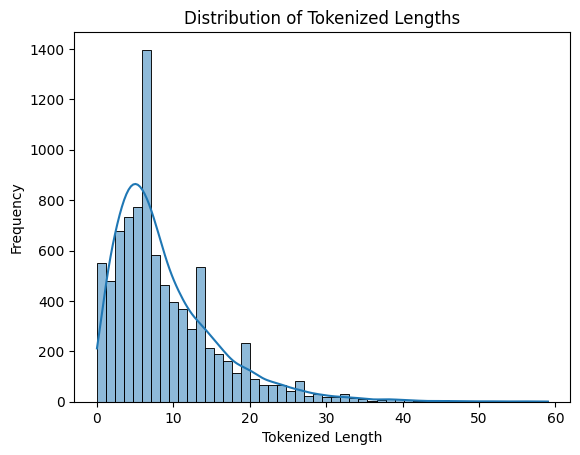

In [13]:
#visual representation of token lenght column
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(train_conv["token_length"], bins=50, kde=True)
plt.xlabel("Tokenized Length")
plt.ylabel("Frequency")
plt.title("Distribution of Tokenized Lengths")
plt.show()

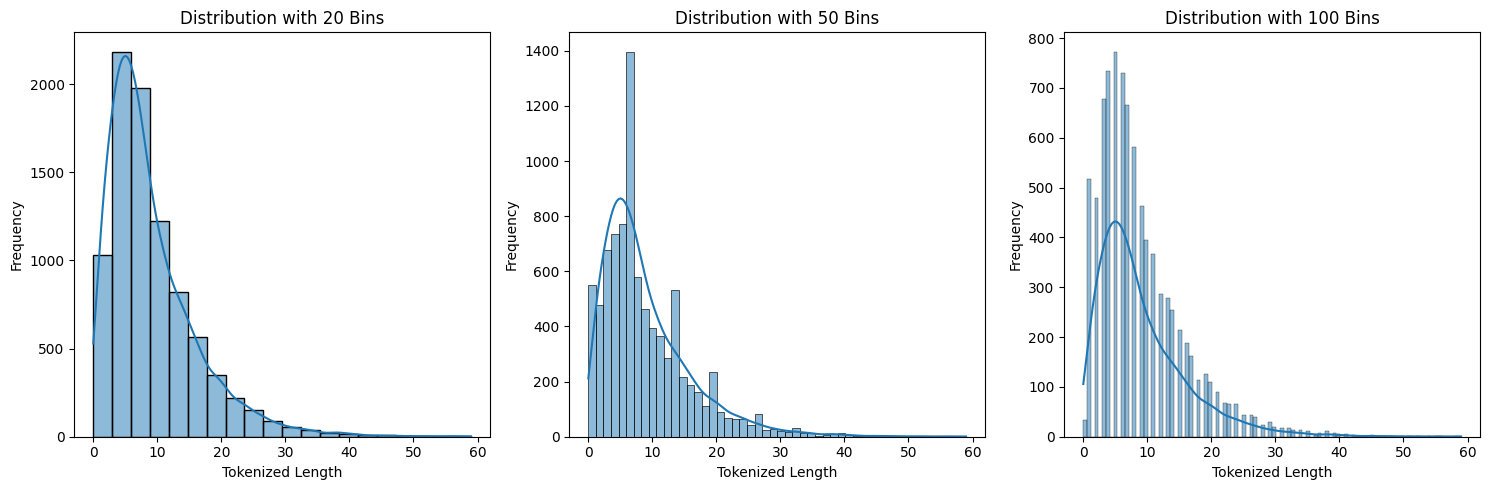

In [14]:
# Key findings from the above histogram - Right-Skewed Distribution - Most tokenized essay lengths are below 20, with a long tail. Peak Around 5-10 Tokens.
#To analyze the distribution more effectively:
#Plotting three subplots with different bin sizes (20, 50, 100) for better visualization
bin_sizes = [20, 50, 100]  

plt.figure(figsize=(15, 5))

for i, bins in enumerate(bin_sizes, 1):
    plt.subplot(1, 3, i)
    sns.histplot(train_conv["token_length"], bins=bins, kde=True)
    plt.xlabel("Tokenized Length")
    plt.ylabel("Frequency")
    plt.title(f"Distribution with {bins} Bins")

plt.tight_layout()
plt.show()

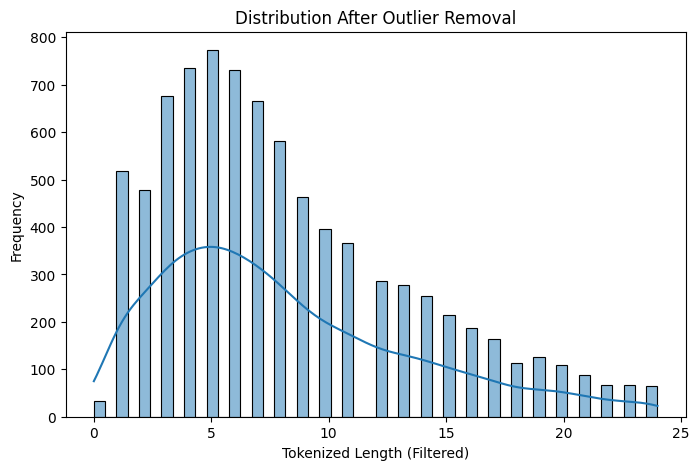

In [15]:
# Computing IQR (Interquartile Range (IQR) Explained) and defining outlier thresholds. It will filter values beyond 1.5 × IQR to remove extreme points.
# Plots the cleaned distribution for better insights.
Q1 = np.percentile(train_conv["token_length"], 25)
Q3 = np.percentile(train_conv["token_length"], 75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter data (remove outliers)
filtered_data = train_conv[(train_conv["token_length"] >= lower_bound) & 
                           (train_conv["token_length"] <= upper_bound)]

# Plot the cleaned distribution
plt.figure(figsize=(8, 5))
sns.histplot(filtered_data["token_length"], bins=50, kde=True)
plt.xlabel("Tokenized Length (Filtered)")
plt.ylabel("Frequency")
plt.title("Distribution After Outlier Removal")
plt.show()


##### Interquartile Range (IQR) Explained: The Interquartile Range (IQR) is a measure of statistical dispersion, which represents the middle 50% of the data. It helps in identifying outliers.Formula 𝐼QR = Q3-Q1. Q1 (First Quartile, 25th percentile): The value below which 25% of the data falls. Q3 (Third Quartile, 75th percentile): The value below which 75% of the data falls. IQR: The range covering the central 50% of the data.


In [16]:
filtered_data

,conversation_id,turn_id,text,EmotionalPolarity,Emotion,Empathy,speaker_number,article_id,speaker_id,essay_id,clean_text,preprocessed_text,token_length
0,2,0,I feel very sad for the people.,2.0000,3.0000,3.3333,1,35.0,30.0,1.0,i feel very sad for the people,feel sad people,3
1,2,1,It's terrible. Not only the people but the ani...,2.0000,4.0000,3.3333,2,35.0,17.0,501.0,its terrible not only the people but the anima...,'s terrible people animal well,5
2,2,10,I felt really sorry for the sister that now ha...,2.0000,3.6667,2.6667,1,35.0,30.0,1.0,i felt really sorry for the sister that now ha...,felt really sorry sister rise sibling,6
3,2,11,"Yeah, it's going to be tough but i am sure she...",0.6667,3.0000,2.0000,2,35.0,17.0,501.0,yeah its going to be tough but i am sure she i...,yeah 's going tough sure strong enough raise,8
4,2,12,"Yeah, we never know what we can do unless we a...",0.3333,2.3333,1.3333,1,35.0,30.0,1.0,yeah we never know what we can do unless we ar...,yeah never know unless tested,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8769,58,3,I think you are right about cracking down on t...,2.0000,2.0000,2.0000,2,72.0,46.0,557.0,i think you are right about cracking down on t...,think right cracking buyer maybe trying stop p...,19
8772,58,6,"Oh exactly, it always comes down to the money....",0.0000,2.0000,2.0000,1,72.0,44.0,57.0,oh exactly it always comes down to the money s...,oh exactly always come money stop able make pr...,13
8773,58,7,And when it's the officials who are getting pa...,2.0000,2.0000,2.0000,2,72.0,46.0,557.0,and when its the officials who are getting pai...,'s official getting paid one supposed stopping...,10
8774,58,8,Yes corruption I'm sure is very huge. It has t...,2.0000,3.0000,3.0000,1,72.0,44.0,57.0,yes corruption im sure is very huge it has to ...,yes corruption 'm sure huge take everyone page...,23


In [17]:
# Feature and target variables
X = train_conv['preprocessed_text']  
y = train_conv[['Emotion', 'Empathy']]

# Split into training and testing data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [18]:
# Vectorizing the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [19]:
# Initializing models for Emotion and Empathy and making a dictionary to hold the models
lr_model = LogisticRegression(random_state=42, max_iter=1000)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
gb_model = GradientBoostingRegressor(random_state=42)
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.2)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

models = {
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model,
    'Support Vector Regression': svr_model,
    'XGBoost': xgb_model
}


In [20]:
# Training and doing evaluation for each model with respect to emotion and empathy and doing prediction along with Calculating R² and F1 score

from sklearn.metrics import r2_score, mean_squared_error, f1_score

evaluation_results = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    model.fit(X_train_tfidf, y_train['Emotion'])
    y_pred_emotion = model.predict(X_test_tfidf)
    
    model.fit(X_train_tfidf, y_train['Empathy'])
    y_pred_empathy = model.predict(X_test_tfidf)
    
    # Calculating R² and MSE for Emotion and Empathy
    emotion_r2 = r2_score(y_test['Emotion'], y_pred_emotion)
    emotion_mse = mean_squared_error(y_test['Emotion'], y_pred_emotion)
    empathy_r2 = r2_score(y_test['Empathy'], y_pred_empathy)
    empathy_mse = mean_squared_error(y_test['Empathy'], y_pred_empathy)

    # Convert Regression Outputs to Class Labels
    y_test_emotion_class = np.round(y_test['Emotion']).astype(int)
    y_pred_emotion_class = np.round(y_pred_emotion).astype(int)
    y_test_empathy_class = np.round(y_test['Empathy']).astype(int)
    y_pred_empathy_class = np.round(y_pred_empathy).astype(int)

    # Ensuring valid class range
    y_test_emotion_class = np.clip(y_test_emotion_class, 0, np.max(y_test_emotion_class))
    y_pred_emotion_class = np.clip(y_pred_emotion_class, 0, np.max(y_test_emotion_class))
    y_test_empathy_class = np.clip(y_test_empathy_class, 0, np.max(y_test_empathy_class))
    y_pred_empathy_class = np.clip(y_pred_empathy_class, 0, np.max(y_test_empathy_class))

    # Computing F1 Scores for Emotions and Emathy
    emotion_f1 = f1_score(y_test_emotion_class, y_pred_emotion_class, average="weighted")
    empathy_f1 = f1_score(y_test_empathy_class, y_pred_empathy_class, average="weighted")

    
    # To store results
    evaluation_results[model_name] = {
        'Emotion R²': emotion_r2,
        'Emotion MSE': emotion_mse,
        'Emotion F1': emotion_f1,
        'Empathy R²': empathy_r2,
        'Empathy MSE': empathy_mse,
        'Empathy F1': empathy_f1
    }

# To display evaluation results
pd.DataFrame(evaluation_results).T


Training Random Forest...
Training Gradient Boosting...
Training Support Vector Regression...
Training XGBoost...


,Emotion R²,Emotion MSE,Emotion F1,Empathy R²,Empathy MSE,Empathy F1
Random Forest,0.295672,0.470374,0.503918,0.294484,0.586380,0.445974
Gradient Boosting,0.256893,0.496272,0.473251,0.269589,0.607071,0.387016
Support Vector Regression,0.359679,0.427628,0.514044,0.368646,0.524742,0.441455
XGBoost,0.300746,0.466985,0.493213,0.313508,0.570569,0.423720


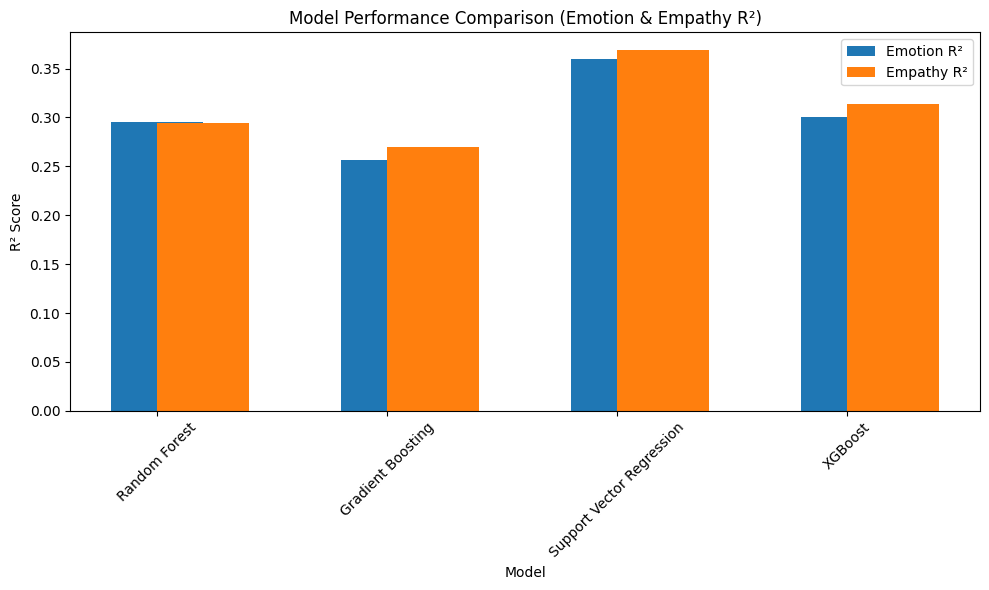

In [21]:
import matplotlib.pyplot as plt

# Plotting Emotion and Empathy R² for each model
emotion_r2 = [evaluation_results[model]['Emotion R²'] for model in models]
empathy_r2 = [evaluation_results[model]['Empathy R²'] for model in models]

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(models.keys(), emotion_r2, width=0.4, label='Emotion R²', align='center')
ax.bar(models.keys(), empathy_r2, width=0.4, label='Empathy R²', align='edge')

ax.set_xlabel('Model')
ax.set_ylabel('R² Score')
ax.set_title('Model Performance Comparison (Emotion & Empathy R²)')
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


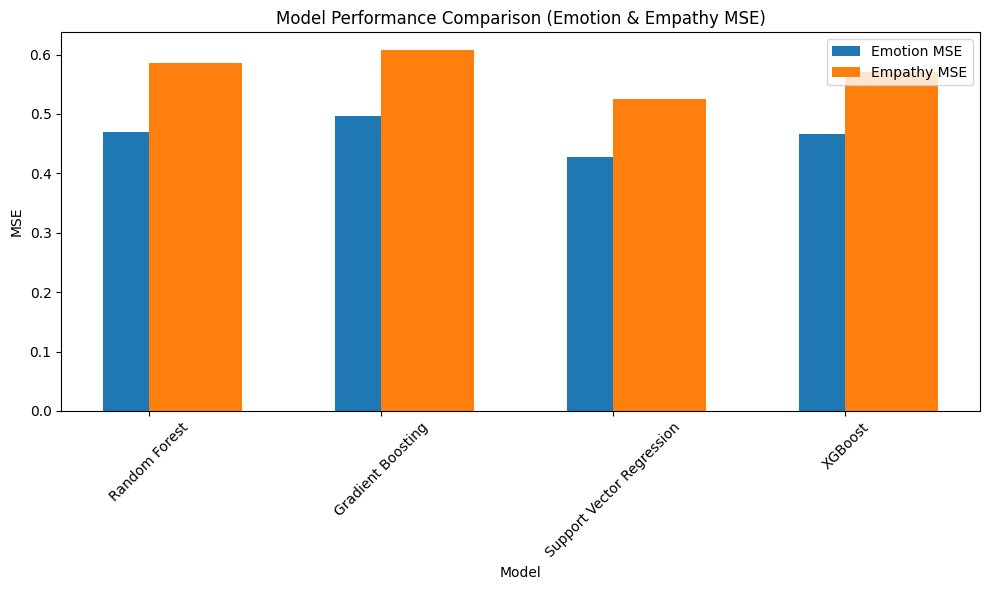

In [22]:
# Plotting Emotion and Empathy MSE for each model
emotion_mse = [evaluation_results[model]['Emotion MSE'] for model in models]
empathy_mse = [evaluation_results[model]['Empathy MSE'] for model in models]

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(models.keys(), emotion_mse, width=0.4, label='Emotion MSE', align='center')
ax.bar(models.keys(), empathy_mse, width=0.4, label='Empathy MSE', align='edge')

ax.set_xlabel('Model')
ax.set_ylabel('MSE')
ax.set_title('Model Performance Comparison (Emotion & Empathy MSE)')
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


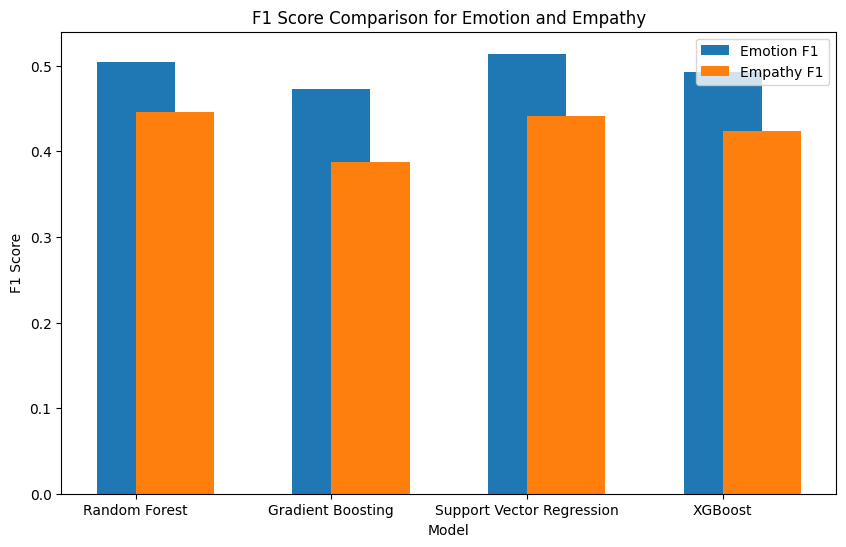

In [23]:
# Plotting Emotion and Empathy F1 scores for each model
emotion_f1 = [evaluation_results[model]['Emotion F1'] for model in models]
empathy_f1 = [evaluation_results[model]['Empathy F1'] for model in models]

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(models.keys(), emotion_f1, width=0.4, label='Emotion F1', align='center')
ax.bar(models.keys(), empathy_f1, width=0.4, label='Empathy F1', align='edge')

ax.set_xlabel('Model')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Score Comparison for Emotion and Empathy')
ax.legend()

plt.show()

In [24]:
# Finding the best model with the highest average R² for both Emotion and Empathy
best_model_name = max(evaluation_results, key=lambda model: (evaluation_results[model]['Emotion R²'] + evaluation_results[model]['Empathy R²']) / 2)

print(f"The best model is: {best_model_name}")
best_model = models[best_model_name]


The best model is: Support Vector Regression


In [25]:
test_conv = pd.read_csv('C:/Users/Its Me/Desktop/test_conv.tsv', sep='\t')


# Preprocess the text data in the test set
test_conv['preprocessed_text'] = test_conv['text'].apply(preprocess_text)

test_conv.head()

,conversation_id,turn_id,text,speaker_number,article_id,speaker_id,essay_id,preprocessed_text
0,1059,1,"Hello, did you read the article?",1,6,92,3,hello read article
1,1059,2,"Hello. Yes i am currently reading it now, fini...",2,6,53,2,hello yes currently reading finishing u think
2,1059,3,Feel saddened by this event. It's 2023 and we ...,1,6,92,3,feel saddened event 's 2023 still face somethi...
3,1059,4,when did these events in the article take plac...,2,6,53,2,event article take place trying find
4,1059,5,I don't think they mentioned it. The final par...,1,6,92,3,n't think mentioned final paragraph 2015 event...


In [26]:
# Vectorize the processed text in the test set using the same TF-IDF vectorizer
X_test_tfidf_final = vectorizer.transform(test_conv['preprocessed_text'])

# Predict Emotion and Empathy on the test data using the best model
predicted_emotion = best_model.predict(X_test_tfidf_final)
predicted_empathy = best_model.predict(X_test_tfidf_final)

# Add the predicted values to the test dataframe
test_conv['Predicted_Emotion'] = predicted_emotion
test_conv['Predicted_Empathy'] = predicted_empathy

# Display the predictions for the test data
test_conv[['text', 'Predicted_Emotion', 'Predicted_Empathy']].head()


,text,Predicted_Emotion,Predicted_Empathy
0,"Hello, did you read the article?",1.378035,1.378035
1,"Hello. Yes i am currently reading it now, fini...",1.901648,1.901648
2,Feel saddened by this event. It's 2023 and we ...,2.559704,2.559704
3,when did these events in the article take plac...,1.919744,1.919744
4,I don't think they mentioned it. The final par...,1.911757,1.911757


In [27]:
# Define a mapping function
def map_emotion(prediction):
    if prediction < 1.5:
        return "Sad"
    elif 1.5 <= prediction < 2.5:
        return "Neutral"
    elif 2.5 <= prediction < 3.5:
        return "Happy"
    else:
        return "Angry"

test_conv['Predicted_Emotion_Label'] = test_conv['Predicted_Emotion'].apply(map_emotion)

test_conv[['text', 'Predicted_Emotion_Label', 'Predicted_Empathy']].head()


,text,Predicted_Emotion_Label,Predicted_Empathy
0,"Hello, did you read the article?",Sad,1.378035
1,"Hello. Yes i am currently reading it now, fini...",Neutral,1.901648
2,Feel saddened by this event. It's 2023 and we ...,Happy,2.559704
3,when did these events in the article take plac...,Neutral,1.919744
4,I don't think they mentioned it. The final par...,Neutral,1.911757


In [28]:
from nltk.util import ngrams

def generate_ngrams(text, n=2):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word not in string.punctuation]
    bigrams = ['_'.join(gram) for gram in ngrams(tokens, n)]
    return ' '.join(tokens + bigrams)

train_conv['preprocessed_text'] = train_conv['text'].apply(generate_ngrams)
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error, f1_score

# Assuming 'train_conv' has already been preprocessed with bigrams and vectorized
X = train_conv['preprocessed_text']  # Processed text data with bigrams
y = train_conv[['Emotion', 'Empathy']]  # Targets (Emotion and Empathy)

# Split into training and testing data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorizing the text data using TF-IDF (with bigrams)
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))  # Bigram range (1, 2)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Initializing models for Emotion and Empathy and making a dictionary to hold the models
lr_model = LogisticRegression(random_state=42, max_iter=1000)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
gb_model = GradientBoostingRegressor(random_state=42)
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.2)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

models = {
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model,
    'Support Vector Regression': svr_model,
    'XGBoost': xgb_model
}

# Training and evaluating models with bigram features
evaluation_results = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    model.fit(X_train_tfidf, y_train['Emotion'])
    y_pred_emotion = model.predict(X_test_tfidf)
    
    model.fit(X_train_tfidf, y_train['Empathy'])
    y_pred_empathy = model.predict(X_test_tfidf)
    
    # Calculating R² and MSE for Emotion and Empathy
    emotion_r2 = r2_score(y_test['Emotion'], y_pred_emotion)
    emotion_mse = mean_squared_error(y_test['Emotion'], y_pred_emotion)
    empathy_r2 = r2_score(y_test['Empathy'], y_pred_empathy)
    empathy_mse = mean_squared_error(y_test['Empathy'], y_pred_empathy)

    # Convert Regression Outputs to Class Labels
    y_test_emotion_class = np.round(y_test['Emotion']).astype(int)
    y_pred_emotion_class = np.round(y_pred_emotion).astype(int)
    y_test_empathy_class = np.round(y_test['Empathy']).astype(int)
    y_pred_empathy_class = np.round(y_pred_empathy).astype(int)

    # Ensuring valid class range
    y_test_emotion_class = np.clip(y_test_emotion_class, 0, np.max(y_test_emotion_class))
    y_pred_emotion_class = np.clip(y_pred_emotion_class, 0, np.max(y_test_emotion_class))
    y_test_empathy_class = np.clip(y_test_empathy_class, 0, np.max(y_test_empathy_class))
    y_pred_empathy_class = np.clip(y_pred_empathy_class, 0, np.max(y_test_empathy_class))

    # Computing F1 Scores for Emotions and Empathy
    emotion_f1 = f1_score(y_test_emotion_class, y_pred_emotion_class, average="weighted")
    empathy_f1 = f1_score(y_test_empathy_class, y_pred_empathy_class, average="weighted")

    # To store results
    evaluation_results[model_name] = {
        'Emotion R²': emotion_r2,
        'Emotion MSE': emotion_mse,
        'Emotion F1': emotion_f1,
        'Empathy R²': empathy_r2,
        'Empathy MSE': empathy_mse,
        'Empathy F1': empathy_f1
    }

# To display evaluation results
pd.DataFrame(evaluation_results).T


Training Random Forest...
Training Gradient Boosting...
Training Support Vector Regression...
Training XGBoost...


,Emotion R²,Emotion MSE,Emotion F1,Empathy R²,Empathy MSE,Empathy F1
Random Forest,0.286960,0.476192,0.504300,0.291924,0.588508,0.451402
Gradient Boosting,0.256165,0.496758,0.477480,0.267354,0.608929,0.386334
Support Vector Regression,0.341900,0.439501,0.522708,0.348472,0.541509,0.450463
XGBoost,0.282608,0.479099,0.483202,0.309204,0.574146,0.422148
